In [1]:
# get yelp data

In [2]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz

--2019-03-08 22:00:00--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.111.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.111.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz’

yelp_review_polarit 100%[===================>] 158.67M  44.9MB/s    in 4.0s    

2019-03-08 22:00:04 (39.3 MB/s) - ‘yelp_review_polarity_csv.tgz’ saved [166373201/166373201]



In [3]:
 # unzip tar

In [4]:
 !tar -xvzf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [5]:
# import key functions and modules from fastai

In [1]:
from fastai import * 
from fastai.text import * 
from fastai.core import *

In [2]:
 # set path to files

In [3]:
path = Path('yelp_review_polarity_csv')
bs=48

In [4]:
 # load training and view data

In [5]:
train_csv = path/'train.csv'
train = pd.read_csv(train_csv, header=None) 
train.head()

,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [6]:
train.iloc[0][1]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

In [7]:
train[0].unique()

array([1, 2])

In [8]:
 # load and view test/validation data

In [9]:
valid_csv = path/'test.csv'
valid = pd.read_csv(valid_csv, header=None) 
valid.head()

,0,1
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [10]:
valid[0].unique()

array([2, 1])

In [11]:
data_lm = TextLMDataBunch.from_csv(path, 'test.csv')
data_clas = TextClasDataBunch.from_csv(path, 'test.csv', vocab=data_lm.train_ds.vocab, bs=bs)

In [12]:
data_lm.show_batch()

idx,text
0,"for our drinks , xxup bj had a xxmaj bloody xxmaj mary and i had a xxmaj bellini . xxmaj we were served a basket of xxunk bread and mini muffins . xxmaj for appetizers , we got a xxmaj three xxmaj sisters xxmaj farms xxunk greens and smoked salmon and truffled potato cake . xxmaj very good . xxmaj for entrees we selected a jumbo lump crab & tomato"
1,"selection and the self wash is top notch . xxmaj they use premium dog shampoos and conditioners , the tubs are huge and easy for our pooches to get into , and always so clean . i have n't had a chance to use their professional groomer , but all the dogs i have seen leave there have looked cute and happy . xxmaj so glad a self wash is"
2,"very much like cheap patio furniture ( it is a party pool during the day after all ) , and a table that felt like a cheap patio table . xxmaj there was one xxunk cushion thing offered as well . xxmaj our table for 8 really only sat 4 , but maybe this is normal at clubs , not sure . i know the point is n't to sit"
3,"xxmaj fremont while waiting for our food . "" xxunk prohibition ends , xxmaj fremont stunned to discover whiskey had been illegal "" \n \n xxmaj for my breakfast i went with eggs xxmaj benedict which was on point ! xxmaj perfect hollandaise sauce ! \n \n xxmaj overall menu is very basic but very good . xxmaj wait staff helpful and fun . xxmaj ca nt wait"
4,tiny stage and a bunch of fake xxunk sofas some of which actually had tears in them . xxmaj the vodka / club soda was ridiculously watered down both times my friend ordered it and they were over $ 10 each . xxmaj we saw 4 girls dance on stage and i do nt think i saw one actual dance move . \n \n i saw two guys getting


In [13]:
data_clas.show_batch()

text,target
"xxbos xxmaj the mess pretty much started as we ( the xxup gf , e - xxmaj xxunk , and xxmaj funky xxmaj cold xxmaj medina and i ) opened the door . xxmaj there was an older woman behind the counter , just by looking at her , you could tell she was have a bad time . xxmaj there was another group of guys who were saying that",1
"xxbos xxmaj even the best food and atmosphere can taste horrendous after lackluster service and poor response . xxmaj until the current manager changes the way he handles complaints , i give this place only five more years . \n \n xxmaj the restaurant was maybe 3 / xxunk full , so i was expecting faster service than the times i have been here when it was jam -",1
"xxbos xxmaj when you walk through the door you 're greeted with an amazing smell ( reminded me of when my dad would cook meat in our smoker with apple wood chips when we were kids ) . xxmaj second was how great the restaurant looked , it was clean and inviting . xxmaj the bartender smiled and waved at us like we were old friends and told us to",1
"xxbos i had the distinct pleasure of making the acquaintance of the xxmaj king of our fair city earlier this week . xxmaj at his xxunk , we met up at xxmaj the xxmaj skeptical xxmaj chymist . \n \n xxmaj at first glance , i was nervous that the venue would be incredibly small . xxmaj it 's tucked away in the corner of a shopping center ,",2
"xxbos i 'm only giving this motel a 4 star instead of 5 because i ca n't imagine giving any motel 5 stars . \n \n i have stayed at this motel 4 times now . i stay at this motel because it is close to my favorite mega resort corner , but without the price tag of those mega resorts . xxmaj from this motel i can easily",2


In [14]:
data_clas.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'the']

In [15]:
model_path = path/'models'
model_path.mkdir(exist_ok=True)
url = 'http://files.fast.ai/models/wt103_v1/' 
download_url(f'{url}lstm_wt103.pth', model_path/'lstm_wt103.pth') 
download_url(f'{url}itos_wt103.pkl', model_path/'itos_wt103.pkl')

In [16]:
 # initialize lang model using pre-trained lang models

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=['lstm_wt103', 'itos_wt103'], drop_mult=0.5)

In [18]:
learn.predict('This was such a great ', 50, temperature=1.1, min_p=0.001)

"This was such a great  success and a success . here in europe , new york city held a record on a official website of the national museum that took its name from the state of new york , but it was still a long service . in some people 's opinion , the city"

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


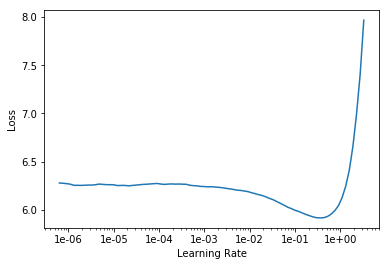

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,4.359298,4.685558,0.171429,05:52


In [22]:
learn.unfreeze()
learn.fit_one_cycle(7, 1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.074266,4.373779,0.242857,07:08
2,3.926634,4.238363,0.285714,07:09
3,3.833415,4.135525,0.285714,07:09
4,3.738532,4.152570,0.271429,07:09
5,3.652145,4.091301,0.285714,07:10
6,3.584393,4.114072,0.285714,07:09
7,3.565036,4.122468,0.285714,07:09


In [23]:
# save fine-tuned model

In [24]:
learn.save_encoder('ft_enc')

In [25]:
learn.predict('It was nice ', 50, temperature=1.1, min_p=0.001)

"It was nice  to have a great food and time experience while looking for authentic Mexican food - it 's small and quiet ! The Carne Asada enchiladas are HIGHLY recommended and my wife had the beef tacos . i had the Mexican burrito and i 'm"

In [26]:
learn.predict('We are never going ', 25, temperature=1.1, min_p=0.001)

'We are never going  to visit this restaurant again . Last night my mother and her boyfriend came here to grab a bottle of water instead of a'

In [27]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [28]:
learn.load_encoder('ft_enc')
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,0.321496,0.202029,0.920789,03:38


In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.245902,0.151680,0.942368,04:47


In [30]:
learn.save('second')


In [31]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (30399 items)
x: TextList
xxbos xxmaj xxunk xxmaj thai is probably the best place to dine in xxmaj anthem in regards to quality of food . xxmaj they have an extensive menu with most of the traditional xxmaj thai dishes along with 
 
  xxmaj here are some recommendations : 
  xxmaj for apps , veggie rolls , crab wontons are ok , but go with the xxmaj satay ~ slices of chicken marinated in curry and grilled . xxmaj it comes with peanut sauce and cucumber dip which is not actually dip , it 's yummy pickled cucumber slices in this ridiculous somewhat sweet sauce that may entice you lick the bowl and ask for more ... 
 
  xxmaj soups ; their xxmaj xxunk xxmaj num ( wonton ) soup is good however i suggest going for the xxmaj tom xxmaj ka xxmaj gai which is a hot / sour soup with chicken , lemon grass , mushrooms , something else not sure what is but taste good in a coconut milk broth served in a " flaming soup xxunk " . 
 
  xxmaj dinner /

In [51]:
s = '''
The Big Boy burger remains a favorite, but they have lost me on there breakfast.  
This is especially true for this store.  Ugh.
'''

In [52]:
prediction = learn.predict(s)

In [53]:
prediction

(<fastai.core.Category at 0x7f638e93d208>, tensor(0), tensor([0.6278, 0.3722]))

In [35]:
learn.data.classes

[1, 2]